In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
# importing libraries
import os
import numpy as np
import torch
import torch.nn as nn
from functools import partial
from torch import save
from fastai.basic_train import Learner
from fastai.train import ShowGraph
from fastai.data_block import DataBunch
from torch import optim
from itertools import product
from skimage.measure import regionprops
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import random
import matplotlib.pyplot as plt
from fastai.vision import DatasetType
from functools import reduce
import torch.nn.functional as F

In [ ]:
!pip install fastai==1.0.59

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

# Dataset

In [ ]:
class FracNetTrainDataset(Dataset):


  # initializing dataset with image & label paths, crop size, transforms, #samples, and mode
    def __init__(self, image_dir, label_dir=None, crop_size=64,
            transforms=None, num_samples=4, train=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        # getting sorted list of public IDs from the image folder filenames
        self.public_id_list = sorted([x.split("-")[0]
            for x in os.listdir(image_dir)])
        self.crop_size = crop_size
        self.transforms = transforms
        self.num_samples = num_samples
        self.train = train

    def __len__(self):
        # returning number of samples in dataset
        return len(self.public_id_list)


    def _get_pos_centroids(label_arr):
      # getting centroids of positive regions in the label array
        centroids = [tuple([round(x) for x in prop.centroid])
            for prop in regionprops(label_arr)]
        return centroids


    def _get_symmetric_neg_centroids(pos_centroids, x_size):
      # getting symmetric negative centroids based on positive centroids
        sym_neg_centroids = [(x_size - x, y, z) for x, y, z in pos_centroids]
        return sym_neg_centroids


    def _get_spine_neg_centroids(shape, crop_size, num_samples):
      # getting random negative centroids within the spine region
        x_min, x_max = shape[0] // 2 - 40, shape[0] // 2 + 40
        y_min, y_max = 300, 400
        z_min, z_max = crop_size // 2, shape[2] - crop_size // 2
        spine_neg_centroids = [(
            np.random.randint(x_min, x_max),
            np.random.randint(y_min, y_max),
            np.random.randint(z_min, z_max)
        ) for _ in range(num_samples)]

        return spine_neg_centroids

    def _get_neg_centroids(self, pos_centroids, image_shape):
      # geting negative centroids by combining symmetric and spine negative centroids
        num_pos = len(pos_centroids)
        sym_neg_centroids = self._get_symmetric_neg_centroids(
            pos_centroids, image_shape[0])

        if num_pos < self.num_samples // 2:
            spine_neg_centroids = self._get_spine_neg_centroids(image_shape,
                self.crop_size, self.num_samples - 2 * num_pos)
        else:
            spine_neg_centroids = self._get_spine_neg_centroids(image_shape,
                self.crop_size, num_pos)

        return sym_neg_centroids + spine_neg_centroids

    def _get_roi_centroids(self, label_arr):
       # generating ROIs' centroids based on the training mode

        if self.train:
            # generating positive samples' centroids
            pos_centroids = self._get_pos_centroids(label_arr)

            # generating negative samples' centroids
            neg_centroids = self._get_neg_centroids(pos_centroids,
                label_arr.shape)

            # sample positives and negatives when necessary
            num_pos = len(pos_centroids)
            num_neg = len(neg_centroids)
            if num_pos >= self.num_samples:
                num_pos = self.num_samples // 2
                num_neg = self.num_samples // 2
            elif num_pos >= self.num_samples // 2:
                num_neg = self.num_samples - num_pos

            if num_pos < len(pos_centroids):
                pos_centroids = [pos_centroids[i] for i in np.random.choice(
                    range(0, len(pos_centroids)), size=num_pos, replace=False)]
            if num_neg < len(neg_centroids):
                neg_centroids = [neg_centroids[i] for i in np.random.choice(
                    range(0, len(neg_centroids)), size=num_neg, replace=False)]
            roi_centroids = pos_centroids + neg_centroids

        else:
          # generate evenly spaced ROIs for validation
            roi_centroids = [list(range(0, x, y // 2))[1:-1] + [x - y // 2]
                for x, y in zip(label_arr.shape, self.crop_size)]
            roi_centroids = list(product(*roi_centroids))

        roi_centroids = [tuple([int(x) for x in centroid])
            for centroid in roi_centroids]
        return roi_centroids

    def _crop_roi(self, arr, centroid):
      # cropping the ROI centered around the centroid
        roi = np.ones(tuple([self.crop_size] * 3)) * (-1024)
        src_beg = [max(0, centroid[i] - self.crop_size // 2)
            for i in range(len(centroid))]
        src_end = [min(arr.shape[i], centroid[i] + self.crop_size // 2)
            for i in range(len(centroid))]
        dst_beg = [max(0, self.crop_size // 2 - centroid[i])
            for i in range(len(centroid))]
        dst_end = [min(arr.shape[i] - (centroid[i] - self.crop_size // 2),
            self.crop_size) for i in range(len(centroid))]
        roi[
            dst_beg[0]:dst_end[0],
            dst_beg[1]:dst_end[1],
            dst_beg[2]:dst_end[2],
        ] = arr[
            src_beg[0]:src_end[0],
            src_beg[1]:src_end[1],
            src_beg[2]:src_end[2],]
        return roi

    def _apply_transforms(self, image):
      # applying transformations on the image
        for t in self.transforms:
            image = t(image)
        return image

    def __getitem__(self, idx):
        # reading image and label
        public_id = self.public_id_list[idx]
        image_path = os.path.join(self.image_dir, f"{public_id}-image.nii")
        label_path = os.path.join(self.label_dir, f"{public_id}-label.nii")
        image = nib.load(image_path)
        label = nib.load(label_path)
        image_arr = image.get_fdata().astype(float)
        label_arr = label.get_fdata().astype(np.uint8)

        # calcualting rois' centroids
        roi_centroids = self._get_roi_centroids(label_arr)

        # cropping rois
        image_rois = [self._crop_roi(image_arr, centroid)
            for centroid in roi_centroids]
        label_rois = [self._crop_roi(label_arr, centroid)
            for centroid in roi_centroids]

        if self.transforms is not None:
            image_rois = [self._apply_transforms(image_roi)
                for image_roi in image_rois]

        image_rois = torch.tensor(np.stack(image_rois)[:, np.newaxis],
            dtype=torch.float)
        label_rois = (np.stack(label_rois) > 0).astype(float)
        label_rois = torch.tensor(label_rois[:, np.newaxis],
            dtype=torch.float)
        return image_rois, label_rois


    def collate_fn(samples):
      # collate funstion to combine multiple samples into a batch
        image_rois = torch.cat([x[0] for x in samples])
        label_rois = torch.cat([x[1] for x in samples])

        return image_rois, label_rois

    def get_dataloader(dataset, batch_size, shuffle=False, num_workers=0):
      # getting dataloader for the dataset
        return DataLoader(dataset, batch_size, shuffle, num_workers=num_workers, collate_fn=FracNetTrainDataset.collate_fn)

## Transformation

In [ ]:
class Window:
  # adjusting image intensity
    def __init__(self, window_min, window_max):
        self.window_min = window_min #min window value
        self.window_max = window_max #max window value

    def __call__(self, image):
        image = np.clip(image, self.window_min, self.window_max) #clip the image values
        return image


class MinMaxNorm:
  # transforming to norm. img values
    def __init__(self, low, high):
        self.low = low # min value in org image
        self.high = high # max value in org image

    def __call__(self, image):
        image = (image - self.low) / (self.high - self.low) # normalize
        image = image * 2 - 1 #scale
        return image


class AddRandomNoise:
  # adding random noise to an image
    def __init__(self, noise_std):
        self.noise_std = noise_std # std of the noise

    def __call__(self, image):
      noise = image * self.noise_std # generaring noise based on image values
      noisy_image = image + noise #adding noise to the image
      return noisy_image

# alternative noise with specified mean and std
class AddGaussianNoise:
    def __init__(self, mean, std):
        self.mean = mean #mean of gaussian noise
        self.std = std #std of gaussian noise

    def __call__(self, image):
      image = torch.from_numpy(image) #converting image to tensor
      noise = torch.randn_like(image) * self.std + self.mean # generating noise
      noise_image = image + noise #adding noise to the image
      return noise_image


## Metrics

In [ ]:
# calculating dice coefficient that measures an overlap between two samples
def dice(x, y, image=False):
    x = x.sigmoid() # applying sigmoid activation to the predictions
    i, u = [t.flatten(1).sum(1) if image else t.sum() for t in [x * y, x + y]]
    dc = ((2 * i + 1) / (u + 1)).mean()
    return dc


# calculating recall that measures the ratio of true positives to actual positives
def recall(x, y, thresh=0.1):
    x = x.sigmoid()
    tp = (((x * y) > thresh).flatten(1).sum(1) > 0).sum() # calculating true positives
    rc = tp / (((y > 0).flatten(1).sum(1) > 0).sum() + 1e-8) # calculating recall
    return rc

# calculating accuracy that measures the ratio of correctly predicted samples to total samples
def accuracy(x, y, thresh=0.5):
    x = x.sigmoid()
    ac = ((x > thresh) == (y > 0)).float().mean()
    return ac

# calculating precision that measures the ratio of true positives to predicted positives
def precision(x, y, thresh=0.1):
    x = x.sigmoid()
    tp = (((x * y) > thresh).flatten(1).sum(1) > 0).sum()
    pc = tp / (((x > thresh).flatten(1).sum(1) > 0).sum() + 1e-8)
    return pc

# calculating F-beta score, a weighted harmonic mean of precision and recall
def fbeta_score(x, y, beta=1, **kwargs):
    rc = recall(x, y, **kwargs)
    pc = precision(x, y, **kwargs)
    fs = (1 + beta ** 2) * pc * rc / (beta ** 2 * pc + rc + 1e-8)
    return fs

# UNet Model

In [ ]:
# defining 3D UNet model
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, first_out_channels=16):
        super().__init__()
        self.first = ConvBlock(in_channels, first_out_channels) # initial conv block
        in_channels = first_out_channels
        self.down1 = Down(in_channels, 2 * in_channels) # first down sampling block
        self.down2 = Down(2 * in_channels, 4 * in_channels) # second down sampling block
        self.down3 = Down(4 * in_channels, 8 * in_channels) # third down sampling block
        self.up1   = Up(8 * in_channels, 4 * in_channels) # first up sampling block
        self.up2   = Up(4 * in_channels, 2 * in_channels) # second up sampling block
        self.up3   = Up(2 * in_channels, in_channels) # thrid up sampling block
        self.final = nn.Conv3d(in_channels, num_classes, 1) # final 1x1 convolution

        # intialising the weights of the conv and batch norm layers
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.first(x) # first conv block
        x2 = self.down1(x1) # first down sampling
        x3 = self.down2(x2) # second down sampling
        x4 = self.down3(x3) # third down sampling
        x  = self.up1(x4, x3) # first up sampling
        x  = self.up2(x, x2) # second up sampling
        x  = self.up3(x, x1) # third up sampling
        x  = self.final(x) # final output layer
        return x


class ConvBlock(nn.Sequential):
  # defining a conv block with two 3x3 convolutions, batch norm and LeakyReLU
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False), # first conv
            nn.BatchNorm3d(out_channels), # batch norm
            nn.LeakyReLU(inplace=True), # LeakyReLU
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False), # second conv
            nn.BatchNorm3d(out_channels), # batch norm
            nn.LeakyReLU(inplace=True)) # LeakyReLU


class Down(nn.Sequential):
  # defining a down sampling block with max pooling and conv block
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool3d(2), # max pool to down sample
            ConvBlock(in_channels, out_channels)) # conv block


class Up(nn.Module):
  # defining up sampling block with transpose conv and conv block
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, 2, stride=2, bias=False), # transpose conv
            nn.BatchNorm3d(out_channels), # batch norm
            nn.LeakyReLU(inplace=True)) # LeakyReLU

    def forward(self, x, y):
        x = self.conv2(x) # up sampling input
        x = self.conv1(torch.cat([y, x], dim=1)) #concatenate and apply conv
        return x

# Losses

In [ ]:
__all__ = ['MixLoss', 'DiceLoss'] # defining public api for model

 # class for combining multiple loss functions
class MixLoss(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.args = args # stroring loss functions and weights

    def forward(self, x, y):
        lf, lfw = [], []
        for i, v in enumerate(self.args):
            if i % 2 == 0:
                lf.append(v)
            else:
                lfw.append(v)
        mx = sum([w * l(x, y) for l, w in zip(lf, lfw)])
        return mx

 # calculating dice loss
class DiceLoss(nn.Module):
    def __init__(self, image=False):
        super().__init__()
        self.image = image

    def forward(self, x, y):
        x = x.sigmoid() # sigmoid for predictions
        i, u = [t.flatten(1).sum(1) if self.image else t.sum() for t in [x * y, x + y]]  # claculating intersection and union
        dc = (2 * i + 1) / (u + 1) # dice coefficient
        dc = 1 - dc.mean() # convert to dice loss
        return dc

# Training

In [ ]:
# defining paths
train_image_dir = "/content/drive/MyDrive/ML/train/train_images"
train_label_dir = "/content/drive/MyDrive/ML/train/train_labels"
val_image_dir = "/content/drive/MyDrive/ML/val/val_images"
val_label_dir = "/content/drive/MyDrive/ML/val/val_labels"

In [ ]:
# defining parameters
batch_size = 4 # try with 16
num_workers = 1 # for parallel processing
optimizer = optim.SGD # defining optimizer
criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1) # loss funtion as a combination of binary cross entropy and dice
thresh = 0.1 # for evaluationmetrics

# creating partial function for eval metrics with soecific threshold
recall_partial = partial(recall, thresh=thresh)
precision_partial = partial(precision, thresh=thresh)
fbeta_score_partial = partial(fbeta_score, thresh=thresh)

epoch,train_loss,valid_loss,dice,recall,precision,fbeta_score,time
0,0.918513,0.900212,0.225496,0.919444,0.419904,0.560443,15:41
1,0.744529,1.183186,0.154763,0.962500,0.417060,0.567828,16:04
2,0.636219,1.033159,0.007158,0.192619,0.700000,0.288810,14:51
3,0.598784,0.849060,0.262393,0.943889,0.407180,0.556516,14:18
4,0.544819,0.525145,0.496363,0.866667,0.529417,0.640209,14:23
5,0.510872,1.045985,0.197435,0.983333,0.409547,0.564853,14:10
6,0.491807,1.087875,0.182968,0.988889,0.409583,0.563567,14:52
7,0.465159,0.620466,0.416518,0.958333,0.437038,0.582324,14:16
8,0.448034,0.528454,0.496173,0.754762,0.785040,0.754539,14:05
9,0.436935,0.459130,0.566530,0.926389,0.655091,0.750278,14:34


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


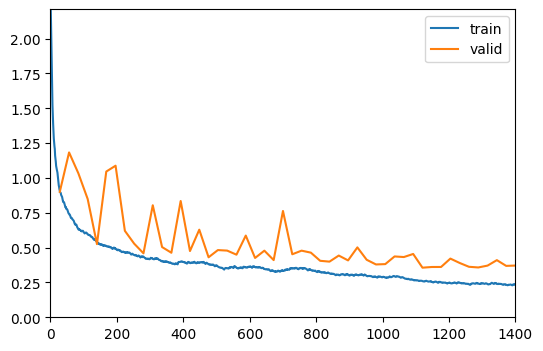

In [ ]:
model = UNet(1, 1, first_out_channels=16) # initialising model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define the device
model.to(device) # move model to the device

# defining list if transformation for preprocessing
transforms = [
    Window(-200, 1000), # adjusting image intensity
    MinMaxNorm(-200, 1000), # normalising pixel values
    #AddRandomNoise(0.1) # tried both
    AddGaussianNoise(0.0, 0.1)] # adding noise

# creating training and validation datasets
ds_train = FracNetTrainDataset(train_image_dir, train_label_dir, transforms=transforms)
dl_train = FracNetTrainDataset.get_dataloader(ds_train, batch_size, False, num_workers)
ds_val = FracNetTrainDataset(val_image_dir, val_label_dir,transforms=transforms)
dl_val = FracNetTrainDataset.get_dataloader(ds_val, batch_size, False,num_workers)

# to hold the training and val dataloaders
databunch = DataBunch(dl_train, dl_val, collate_fn=FracNetTrainDataset.collate_fn)


# learnee object fir training , optimization, loss calculation and metrics
learn = Learner(
    databunch,
    model,
    opt_func=optimizer,
    loss_func=criterion,
    metrics=[dice, recall_partial, precision_partial, fbeta_score_partial])

# training model
learn.fit_one_cycle(
    50, # epochs
    1e-1, # learning rate
    pct_start=0, # percentage of epochs for increasing lr
    div_factor=1000, # factor by which max lris divided at the end of training
    callbacks=[ShowGraph(learn)]) # callbacks for showingtrain and val metrics graphically

# saving trained model
learn.save('/content/drive/MyDrive/ML/Models/Unet50')

# Testing

In [ ]:
# Once we saved the model after training, the next day we needed to load it back for training
# to load it back with the learner, we had to define databunch and other parameters once again
# this time test dataset was added


train_image_dir = "/content/drive/MyDrive/ML/train/train_images"
train_label_dir = "/content/drive/MyDrive/ML/train/train_labels"
val_image_dir = "/content/drive/MyDrive/ML/val/val_images"
val_label_dir = "/content/drive/MyDrive/ML/val/val_labels"
test_image_dir = "/content/drive/MyDrive/ML/new_test/test_images"
test_label_dir = "/content/drive/MyDrive/ML/new_test/test_labels"

batch_size = 4 #try with 16
num_workers = 1
optimizer = optim.SGD
criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1)

thresh = 0.1
recall_partial = partial(recall, thresh=thresh)
precision_partial = partial(precision, thresh=thresh)
fbeta_score_partial = partial(fbeta_score, thresh=thresh)

transforms = [
    Window(-200, 1000),
    MinMaxNorm(-200, 1000),
    AddGaussianNoise(0.0, 0.1)]

ds_train = FracNetTrainDataset(train_image_dir, train_label_dir, transforms=transforms)
dl_train = FracNetTrainDataset.get_dataloader(ds_train, batch_size, False, num_workers)
ds_val = FracNetTrainDataset(val_image_dir, val_label_dir, transforms=transforms)
dl_val = FracNetTrainDataset.get_dataloader(ds_val, batch_size, False, num_workers)
ds_test = FracNetTrainDataset(test_image_dir, test_label_dir, transforms=transforms)
dl_test = FracNetTrainDataset.get_dataloader(ds_test, batch_size, False, num_workers)

databunch = DataBunch(dl_train, dl_val, collate_fn=FracNetTrainDataset.collate_fn)

model = UNet(1, 1, first_out_channels=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# defining learner2 to load back trained model
learn2 = Learner(
    databunch,
    model,
    opt_func=optimizer,
    loss_func=criterion,
    metrics=[dice, recall_partial, precision_partial, fbeta_score_partial])

# loading back saved trained model into learner2
learn2.load('/content/drive/MyDrive/ML/Models/Unet50')

Learner(data=DataBunch;

Train: <__main__.FracNetTrainDataset object at 0x7cfecc5db700>;

Valid: <__main__.FracNetTrainDataset object at 0x7cfed3e12800>;

Test: None, model=UNet(
  (first): ConvBlock(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (down1): Down(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ConvBlock(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

In [ ]:
# funtion to display images long with predicted mask
def show_predictions_3d(image_volume, mask_volume, slice_index):
    if not (0 <= slice_index < image_volume.shape[1]): # cheching if the slice index is within bounds
        raise ValueError(f"Slice index {slice_index} is out of bounds. Valid range is 0 to {image_volume.shape[1]-1}.")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6)) # subplots to disply images and mask
    # slecting the batch [0] and the slice_index on the depth dimension
    ax[0].imshow(image_volume[0, slice_index, :, :], cmap='gray')  # displaying the slice of the original image
    ax[1].imshow(image_volume[0, slice_index, :, :], cmap='gray')  # displaying the same slice for context
    ax[1].imshow(mask_volume[0, slice_index, :, :], alpha=0.5, cmap='jet')  # overlaying the mask with transparency
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1, 64, 64, 64)
(1, 64, 64, 64)


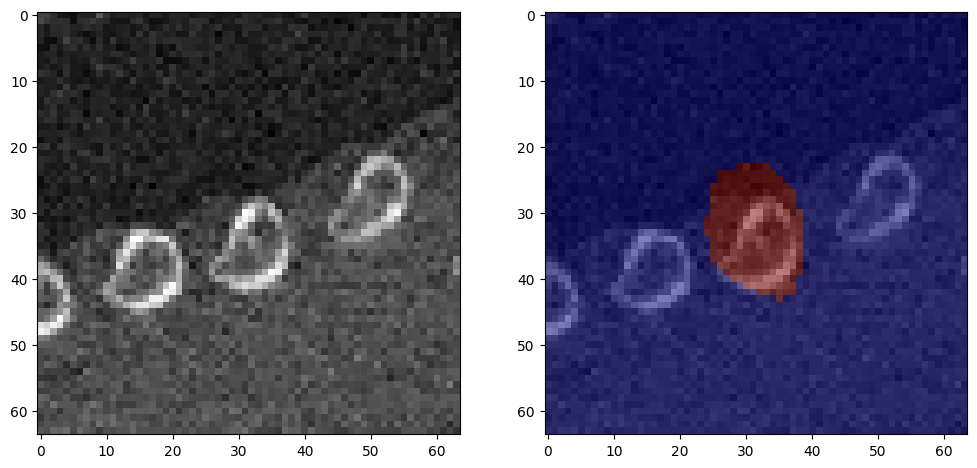

(1, 64, 64, 64)
(1, 64, 64, 64)


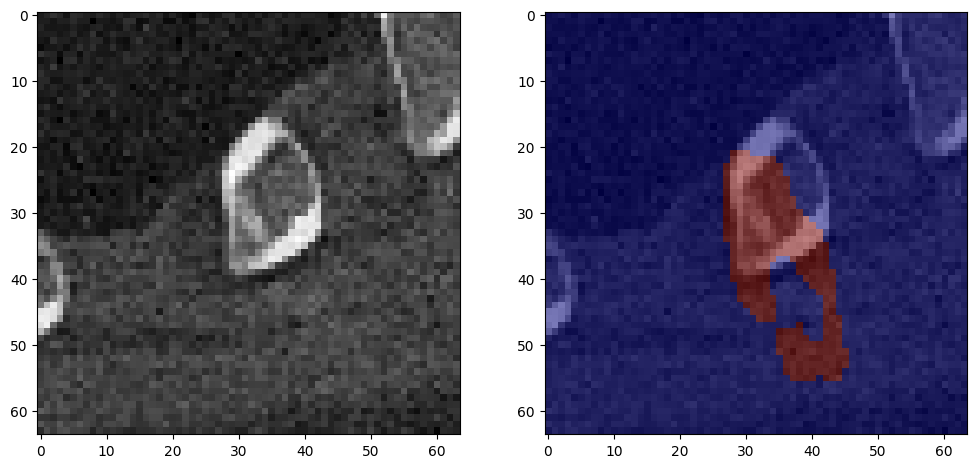

(1, 64, 64, 64)
(1, 64, 64, 64)


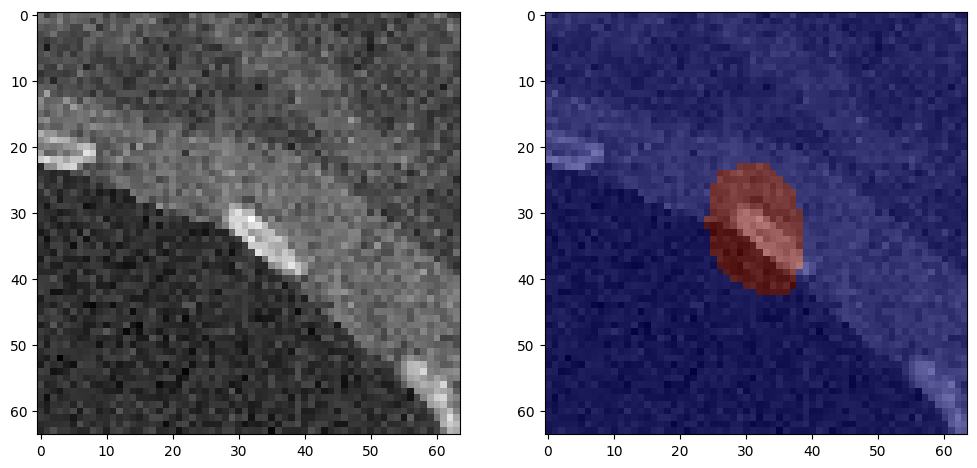

In [ ]:
threshold = 0.5 # for converting predictions to binary mask
# itearte over the test dataloader

for x, y in dl_test:
    #getting predictions from the model
    preds, _ = learn2.get_preds(ds_type=DatasetType.Valid)
    # converting predictions to binary masks based on threshold
    pred_masks = (preds.sigmoid() > threshold).int()
    # visualising the first image in the batch alongside predicted mask
    print(x[0].numpy().shape)
    print(pred_masks[0].numpy().shape)
    show_predictions_3d(x[0].numpy(), pred_masks[0].numpy(), slice_index=32)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(16, 1, 64, 64, 64)
(160, 1, 64, 64, 64)
(16, 1, 64, 64, 64)


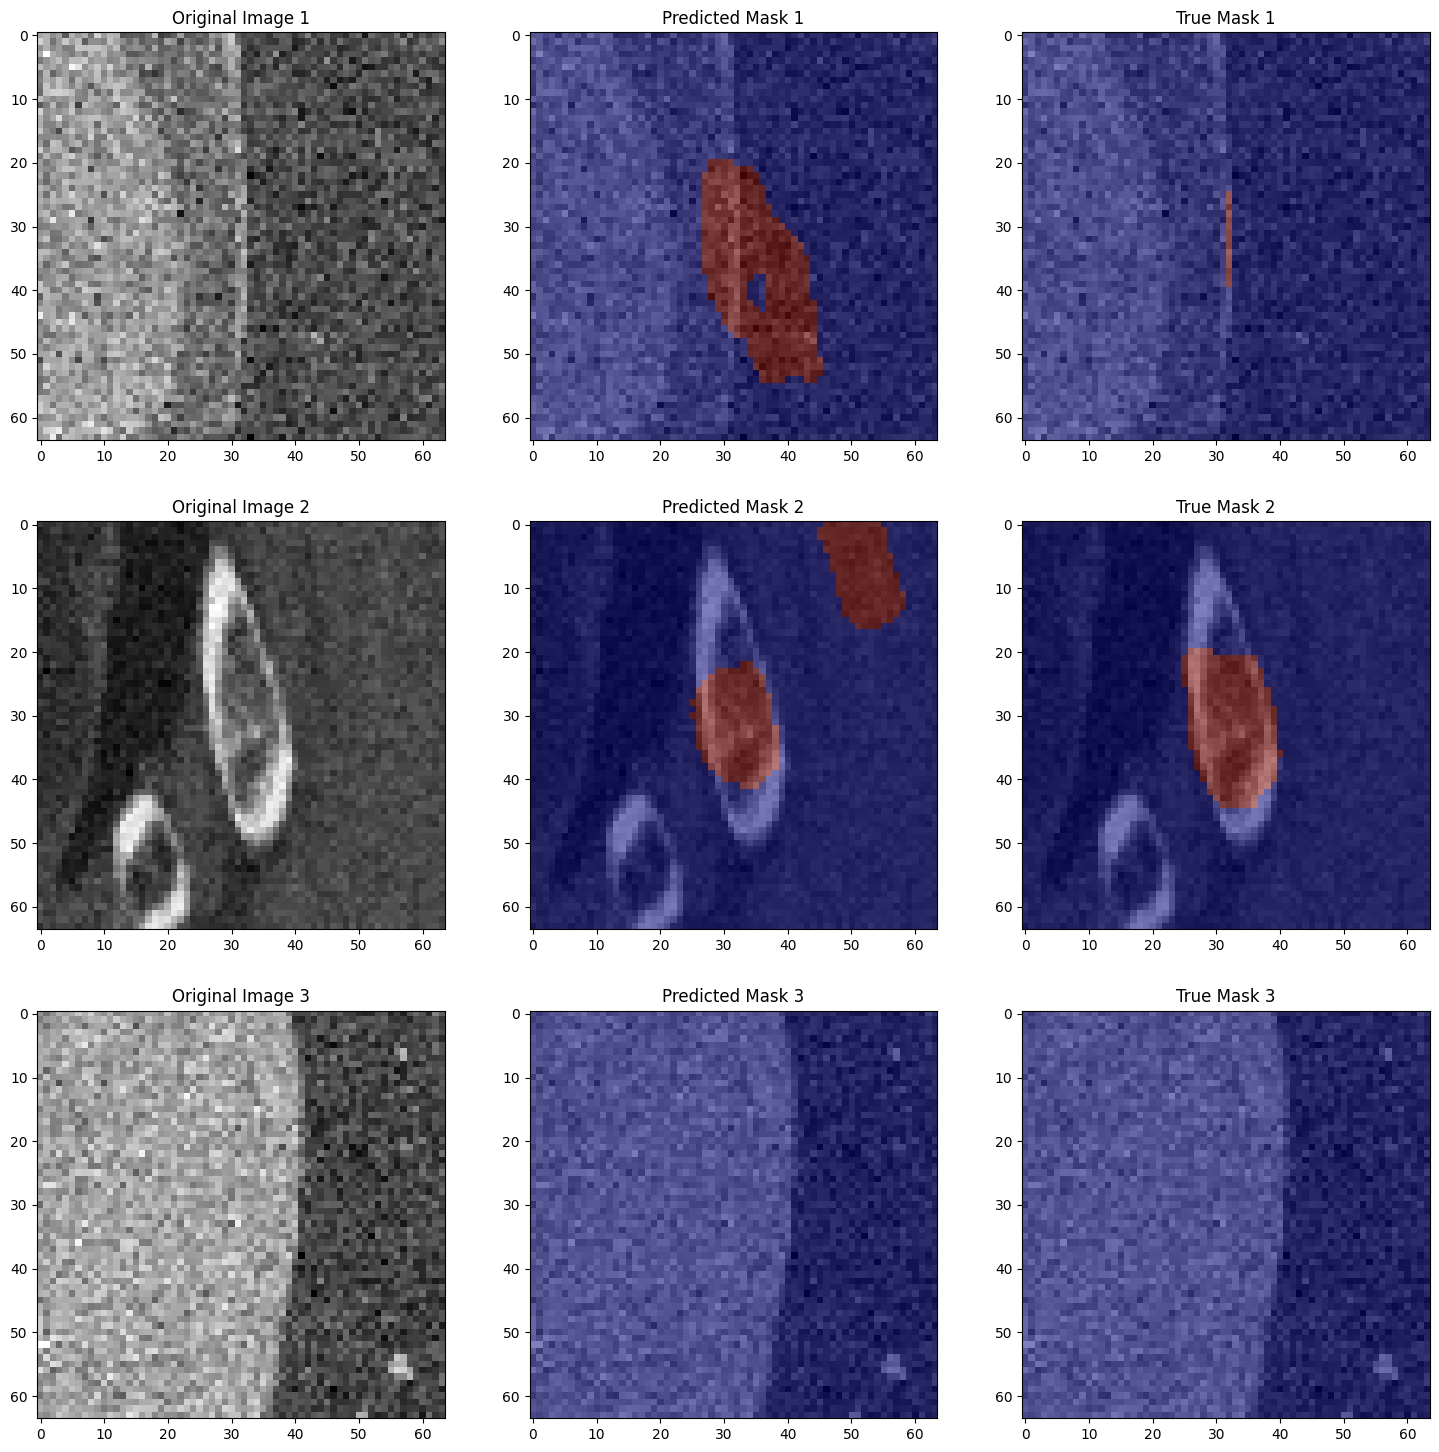

In [ ]:
# alternative way of displaying test predictions together with original mask

def show_predictions_3d(image_volume, pred_mask_volume, true_mask_volume, slice_index, num_instances=3):
    if not (0 <= slice_index < image_volume.shape[2]):
        raise ValueError(f"Slice index {slice_index} is out of bounds. Valid range is 0 to {image_volume.shape[2]-1}.")

    fig, axs = plt.subplots(num_instances, 3, figsize=(18, 6 * num_instances)) #displaying 3 instances

    for i in range(num_instances):
        # displaying slice of org img in the first subplot
        axs[i, 0].imshow(image_volume[i, 0, slice_index, :, :], cmap='gray')
        axs[i, 0].set_title(f"Original Image {i+1}")

        # overlaying predicted mask on org img
        axs[i, 1].imshow(image_volume[i, 0, slice_index, :, :], cmap='gray')  # Display the same slice for context
        axs[i, 1].imshow(pred_mask_volume[i, 0, slice_index, :, :], alpha=0.5, cmap='jet')  # Overlay the predicted mask with transparency
        axs[i, 1].set_title(f"Predicted Mask {i+1}")

        # overlaying true mask on org img
        axs[i, 2].imshow(image_volume[i, 0, slice_index, :, :], cmap='gray')  # Display the same slice for context
        axs[i, 2].imshow(true_mask_volume[i, 0, slice_index, :, :], alpha=0.5, cmap='jet')  # Overlay the true mask with transparency
        axs[i, 2].set_title(f"True Mask {i+1}")

    plt.show()

threshold = 0.1
slice_index = 32  # defining specific slice to visualize
num_instances_to_show = 3

# iterate over test loader
for x, y in dl_test:
    #getting predictions from the model
    preds, _ = learn2.get_preds(ds_type=DatasetType.Valid)
    # converting predictions to binary masks based on threshold
    pred_masks = (preds.sigmoid() > threshold).int()

    #printing shapes
    print(x.numpy().shape)
    print(pred_masks.numpy().shape)
    print(y.numpy().shape)

    # ensuring the num of instances to show does not exceed the batch size
    num_instances_to_show = min(num_instances_to_show, x.size(0))

    # showinig multiple sets of imgs, predictions and true masks
    show_predictions_3d(x.numpy(), pred_masks.numpy(), y.numpy(), slice_index=slice_index, num_instances=num_instances_to_show)

    break